In [27]:
import pandas as pd
from src.data.process_data import fetch_all_matches, load_dls
from src.utils.utils import get_dl_par, dls_winner, handle_datestr, filter_interrupted_matches
from src.visualization.visuals import plot_dls, get_meta_info
import string
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [ ]:
#fetch the data running this in command line 
mkdir all_matches
cd all_matches
wget https://cricsheet.org/downloads/all.zip 
or
wget https://cricsheet.org/downloads/odis.zip 
unzip all.zip

Fetch the data and filter out matches where the 1st innings did not finish to make it simpler

In [2]:
df = fetch_all_matches()
df = df[df['match_id'].isin(filter_interrupted_matches(df))]


2147it [54:31,  1.52s/it]


Load the DLS table

In [3]:
df_dls = load_dls()


Get the DLS par score

In [4]:
df2 = get_dl_par(df, df_dls)


100%|██████████| 1964/1964 [50:48<00:00,  1.55s/it]


filter out to only male and convert dates (there are different formats in the data)

In [11]:
df_male = df2[df2['gender'] == 'male']
df_male['dates'] = df_male['dates'].apply(handle_datestr)

<ipython-input-11-3489c81e1756>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_male['dates'] = df_male['dates'].apply(handle_datestr)


In [12]:
# get number of matches
df_male['match_id'].nunique()

1722

In [36]:
grouped_male = df_male.groupby('over_pre').sum() / df_male.groupby('over_pre').count() * 100
fig_size = (15,10)
fig = plt.Figure(figsize=(15,10))
plt.gcf().set_size_inches(*fig_size)
plt.plot(grouped_male['dls_correct'])
plt.title('Accuracy of Duckworth Lewis Stern at different points in a game (male ODIs)')
plt.xlabel('Overs Bowled')
plt.ylabel('Prediction Accuracy (%)')
plt.ylim(0, 100)
plt.savefig('dls accuracy per over.png')
plt.close()


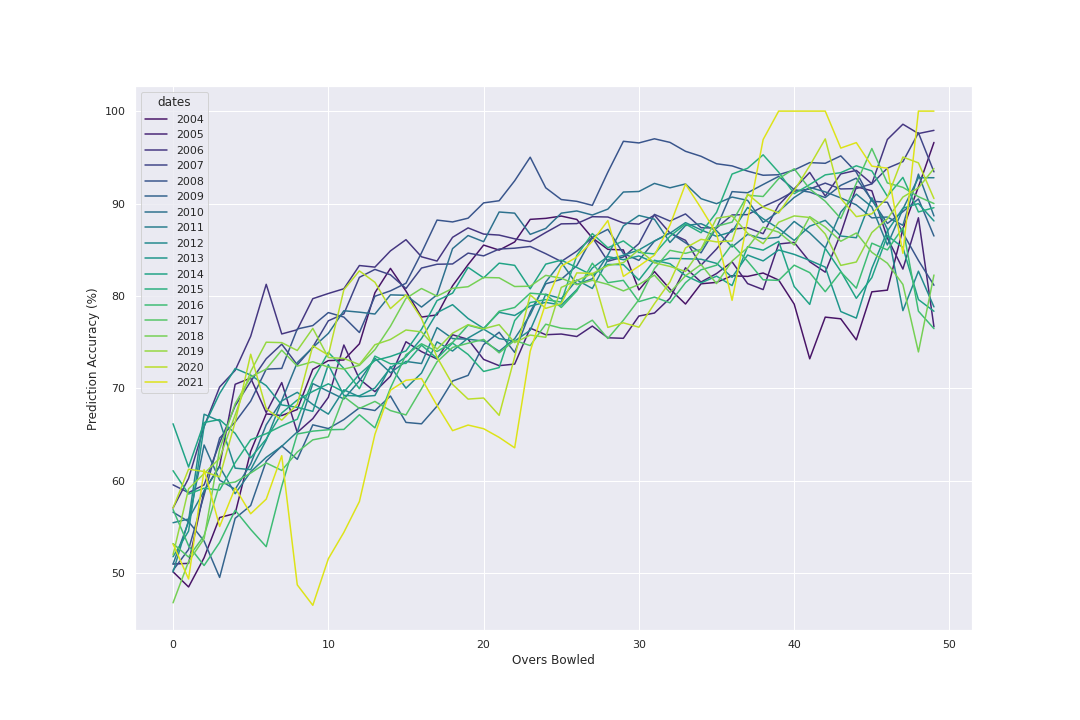

In [37]:
year_group_sum = df_male.groupby(['dates', 'over_pre']).sum()['dls_correct']
year_group_count = df_male.groupby(['dates', 'over_pre']).count()['dls_correct']

by_year_sum = year_group_sum.groupby([pd.Grouper(freq='1y', level='dates'),
                        pd.Grouper(level='over_pre'),]
                        ).sum().reset_index()

by_year_count= year_group_count.groupby([pd.Grouper(freq='1y', level='dates'),
                        pd.Grouper(level='over_pre'),]
                        ).sum().reset_index()                        
by_year_sum['dls_correct'] = by_year_sum['dls_correct'] / by_year_count['dls_correct'] * 100
by_year_sum['dates'] = by_year_sum['dates'].dt.strftime('%Y')

sns.set(rc={'figure.figsize':(15,10)})
sns.lineplot(x='over_pre',
             y='dls_correct',
             data=by_year_sum,
             hue='dates',
             palette='viridis')
plt.xlabel('Overs Bowled')
plt.ylabel('Prediction Accuracy (%)')
plt.savefig('dls_acc_by_year.png')

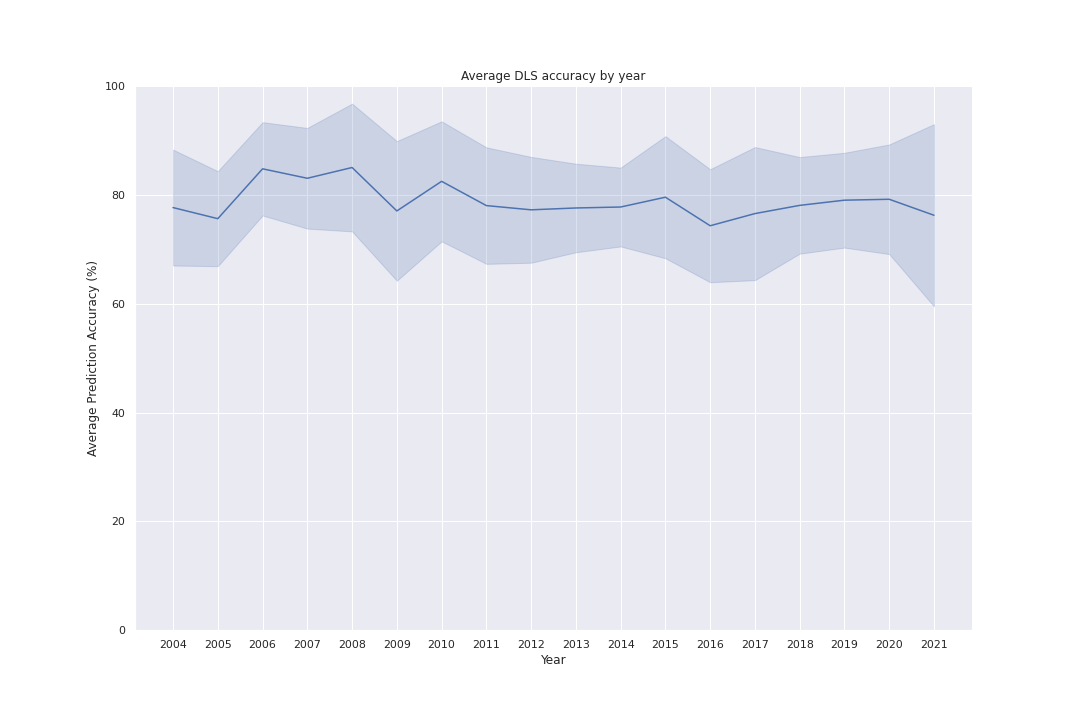

In [38]:
sns.set(rc={'figure.figsize':(15,10)})

sns.lineplot(x='dates',
             y='dls_correct',
             data=by_year_sum,
             ci='sd',
             err_style='band')
sns.despine()
plt.xlabel('Year')
plt.ylabel('Average Prediction Accuracy (%)')
plt.title('Average DLS accuracy by year')
plt.ylim(0, 100)
plt.savefig('avg_acc_by_year.png')

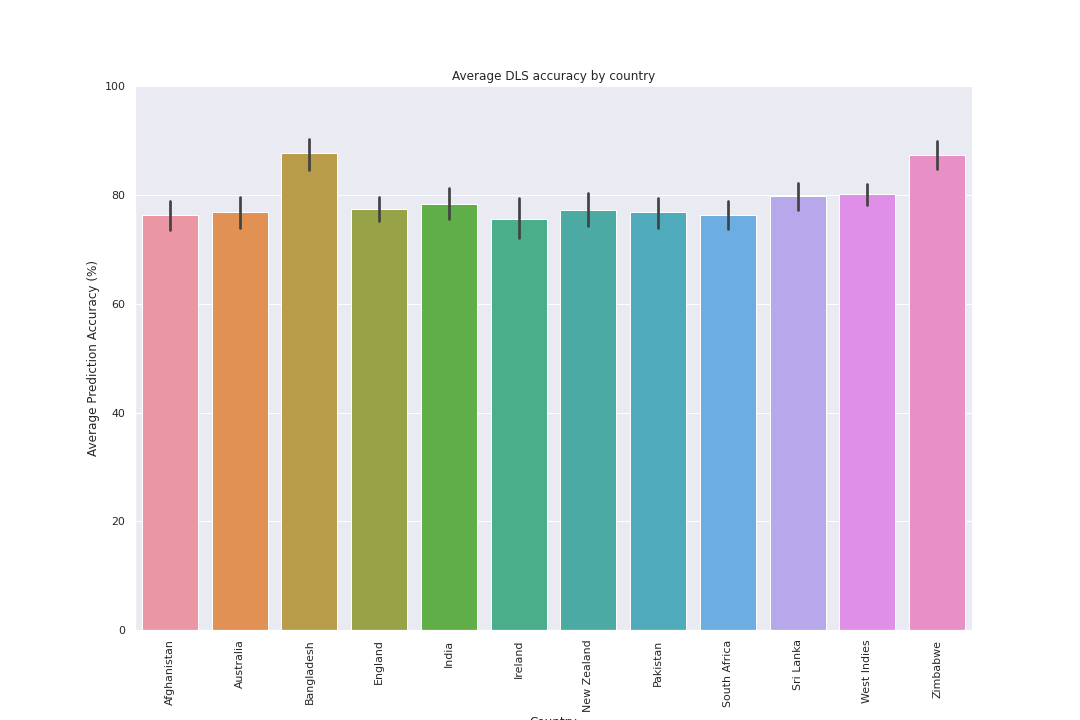

In [39]:
countries = ['Afghanistan', 'Australia', 'Bangladesh', 'England', 'India', 'Ireland', 
 'New Zealand', 'Pakistan', 'South Africa', 'Sri Lanka', 'West Indies', 'Zimbabwe']
df_male = df_male[(df_male['team_1'].isin(countries)) & (df_male['team_2'].isin(countries))]
country_sum = df_male.groupby(['team_2', 'over_pre']).sum()['dls_correct'].reset_index()
country_count = df_male.groupby(['team_2', 'over_pre']).count()['dls_correct'].reset_index()
country_sum['dls_correct'] = country_sum['dls_correct'] / country_count['dls_correct'] * 100
sns.set(rc={'figure.figsize':(15,10)})
sns.barplot(x='team_2',
             y='dls_correct',
             data=country_sum)
sns.despine()
plt.xticks(rotation=90)
plt.xlabel('Country')
plt.ylabel('Average Prediction Accuracy (%)')
plt.title('Average DLS accuracy by country')
plt.ylim(0, 100)
plt.savefig('avg_acc_by_country.png')